In [2]:
# General Qiskit and VQE imports
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit import Aer
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import WikipediaDataProvider
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit import QuantumCircuit
from qiskit.visualization import visualize_transition
# Non-qiskit imports
import math
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
#%matplotlib widget
#%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


print("Libraries imported successfully!")


Libraries imported successfully!


# Variational Quantum Eigensolver

In [3]:
# This function imports stock prices using Quandl and Wikipedia. You can edit the start and end datetimes to consider stock prices over a different time period!
# Data is only availble until April 2018, so use time periods earlier than that.
def import_stock_prices(stocks):
    quandl_token = "HRXZqqxBka_9huabBgoW" 
    wiki = WikipediaDataProvider(
                        token = quandl_token,
                        tickers = stocks,
                        start = datetime.datetime(2016,1,1),
                        end = datetime.datetime(2017,1,1))
    wiki.run()
    return wiki


# This function uses matplotlib to plot normalized stock prices
def plot_stock_prices(stocks, stock_prices, form="norm"):
    fig, ax = plt.subplots(figsize=(8,6))
    if stock_prices._data:
        for (cnt, s) in enumerate(stocks):
            start = stock_prices._data[cnt][0]
            eq = stock_prices._data[cnt] / start
            min_ = np.min(stock_prices._data[cnt])
            max_ = np.max(stock_prices._data[cnt])
            norm = (stock_prices._data[cnt] - min_)/(max_- min_)
            if form == "norm": ax.plot(norm, label=s)
            elif form == "eq": ax.plot(eq, label=s)
            elif form == "raw": ax.plot(stock_prices._data[cnt], label=s)
            else: raise ValueError("Invalid 'form' value")
        ax.legend()
        key = {"norm":"Normalised", "raw":"Raw", "eq":"Equalized"}
        ax.set_title(f"{key[form]} Yearly Evolution of Stock Prices")
        plt.xticks(rotation=90)
        # plt.tight_layout()
        plt.show()
    else:
        print('No wiki data loaded.')

# This Function displays the result of a VQE or Classical Eigensolver
def display_values(vqe_result, stocks):
    lines = []
    for result in vqe_result.samples[:5]:
            qubits, value, probability = result.x, result.fval, result.probability
            q_str = str(qubits.astype(int)).ljust(16)
            arr = np.array(qubits)
            opt = [str(stock[0])+' ' for stock in np.take(stocks, np.argwhere(arr))]
            opt_str = "".join(opt).ljust(16)
            lines.append((opt_str, f'{q_str} {opt_str} {round(value,4)} \t {round(probability,4)}'))

    print(f' Optimal Stock Combination: {lines[0][0]}')
    print('\n------------------------ Top Results ------------------------')
    print('solution \t stocks \t value \t\t probability')
    print('--------------------------------------------------------------')
    [print(p[1]) for p in lines]
    print('--------------------------------------------------------------')

# This function draws the value of the portfolio against other the stocks
def plot_portfolio_against_market(result, stock_prices):
    portfolio_sel = np.argwhere(result.samples[0].x).reshape(-1)
    fig, ax = plt.subplots(figsize=(8,6))
    if stock_prices._data:
        portfolio_sum = []
        for (cnt, s) in enumerate(stocks):
            start = stock_prices._data[cnt][0]
            eq = stock_prices._data[cnt] / start
            if cnt in portfolio_sel:
                portfolio_sum.append(eq)
                ax.plot(eq, label=f"{s} (Selected)", linestyle="--", alpha=0.5)
            else:
                ax.plot(eq, label=s, alpha=0.15)
        sab = sum(portfolio_sum)
        # This has no purpose besides shifting the color because I don't like brown
        next(ax._get_lines.prop_cycler)   
        ax.plot(sab/2, label="Portfolio Value")
        ax.set_title("Portfolio Performance") 
        ax.legend()
        plt.xticks(rotation=90)
        plt.show()

    else:
        print('No wiki data loaded.')

In [4]:
stocks = ["AAPL", "NFLX", "NVDA", "IBM", "GOOG"] # Other stock tickers you can add include F, AMZN, GME, etc. 
stock_prices = import_stock_prices(stocks)

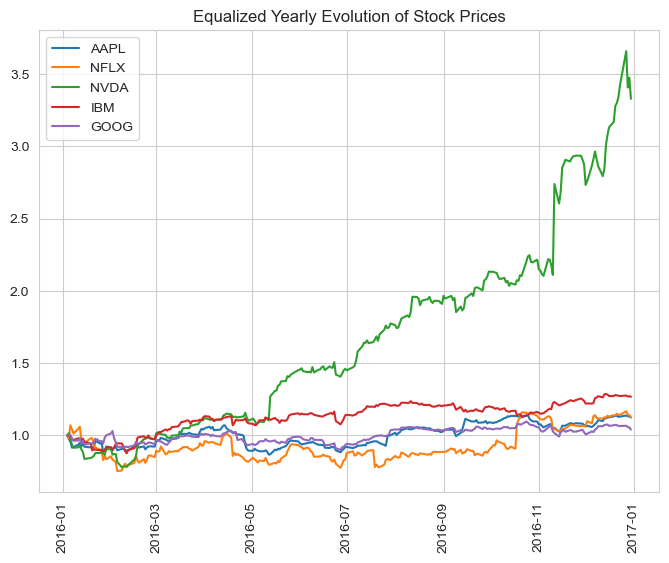

In [5]:
plot_stock_prices(stocks, stock_prices, form="eq")

In [6]:
#num of assets (length of our NASDAQ issues array)
num_assets = len(stocks)
# set budget - how many stocks do you want to buy?
budget = 2
# Defining the portfolio optimization problem
portfolio = PortfolioOptimization(expected_returns=stock_prices.get_period_return_mean_vector(),
                                  covariances=stock_prices.get_period_return_covariance_matrix(),
                                  risk_factor=0.2, budget=budget)
# This creates a quadratic program, which is the form in which the problem can be directly
# passed to Qiskit's solvers
problem = portfolio.to_quadratic_program()

In [7]:
tunable_circuit = EfficientSU2(num_qubits = num_assets, reps = 3, entanglement = 'full') #ET REPS  TO 3
optimizer = SPSA(maxiter = 15)
method = VQE(ansatz = tunable_circuit, optimizer = optimizer, quantum_instance = Aer.get_backend('qasm_simulator'))

In [8]:
tunable_circuit.decompose()

 Optimal Stock Combination: NVDA IBM        

------------------------ Top Results ------------------------
solution 	 stocks 	 value 		 probability
--------------------------------------------------------------
[0 0 1 1 0]      NVDA IBM         -0.006 	 0.0146
[0 1 1 0 0]      NFLX NVDA        -0.0057 	 0.0732
[1 0 1 0 0]      AAPL NVDA        -0.0055 	 0.002
[0 0 1 0 1]      NVDA GOOG        -0.0052 	 0.1348
[0 1 0 1 0]      NFLX IBM         -0.0017 	 0.0547
--------------------------------------------------------------


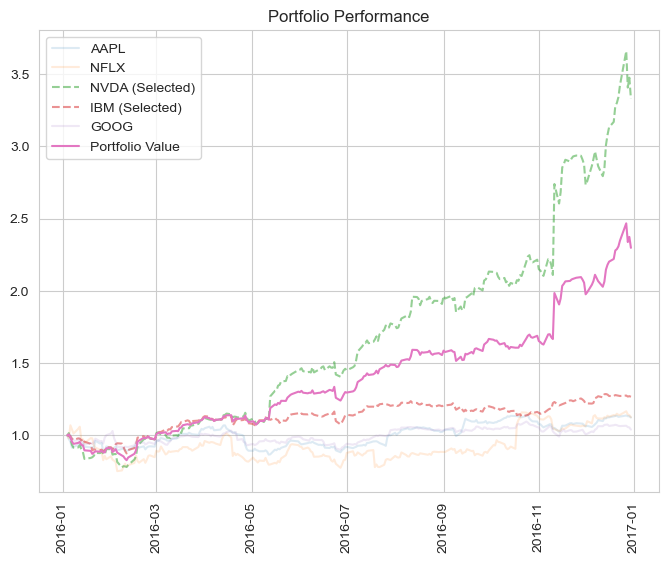

In [9]:
# Solve the Problem
calc = MinimumEigenOptimizer(method)
result = calc.solve(problem)

# Display Results
display_values(result, stocks)
plot_portfolio_against_market(result, stock_prices)